### Import

In [4207]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility

#### Ignore warnings

In [4208]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [4209]:
df = pd.read_csv("./data/nasdaq/csv/NFLX.csv", sep=',')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [4210]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

#### SMA - Simple Moving Average

In [4211]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
# df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
# df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

#### EMA - Exponential Moving Average

In [4212]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
# df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### ADX - Average Directional Movement

In [4213]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### Bollinger Bands

In [4214]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [4215]:
# #consecutive days above sma20
# df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
# df['DASMA'] = 0
# consecutive_count = 0
# r = np.zeros(len(df), dtype=int)
# for i in range(1, len(df)):
#     if df['AboveSMA20'].iloc[i]:
#         consecutive_count += 1
#     else:
#         consecutive_count = 0
#     r[i] = consecutive_count
# df['DASMA'] = r
# df.drop(['AboveSMA20'], axis=1, inplace=True)

In [4216]:
# #consecutive days above sma20
# df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
# df['DBSMA'] = 0
# consecutive_count = 0
# r = np.zeros(len(df), dtype=int)
# for i in range(1, len(df)):
#     if df['BelowSMA20'].iloc[i]:
#         consecutive_count += 1
#     else:
#         consecutive_count = 0
#     r[i] = consecutive_count
# df['DBSMA'] = r
# df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [4217]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

#### Visualize

In [4218]:
start = 6000
vdf = df
# vdf = df[start:start+250]

fig = make_subplots(rows=7, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=7, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1200,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [4219]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df
df = calc_trend(df, n=30, threshold=0.01)

#### Delete invalid data

In [4220]:
df = df[100:-100]
df.index = range(len(df))

In [4221]:
df[5000:5010]

Date        Low       Open        Volume       High      Close  \
5000 2016-05-09  89.900002  90.639999  9.543700e+06  91.830002  90.540001   
5001 2016-05-10  90.540001  90.540001  1.117590e+07  93.250000  92.889999   
5002 2016-05-11  89.900002  92.889999  1.169290e+07  92.889999  90.019997   
5003 2016-05-12  85.739998  90.019997  2.040810e+07  90.410004  87.739998   
5004 2016-05-13  86.260002  87.739998  1.157140e+07  88.589996  87.879997   
5005 2016-05-14  86.223335  87.879997  1.146353e+07  89.059998  88.293332   
5006 2016-05-15  86.186668  88.293332  1.135567e+07  89.529999  88.706668   
5007 2016-05-16  86.150002  88.706668  1.124780e+07  90.000000  89.120003   
5008 2016-05-17  88.169998  89.120003  1.157130e+07  90.870003  88.629997   
5009 2016-05-18  88.250000  88.629997  1.391180e+07  91.720001  90.500000   

      Adjusted Close       RSI7      RSI14      RSI30  ...        ADX  \
5000       90.540001  37.464547  36.475178  41.105692  ...  41.459280   
5001       92.889999  57.310984  45.265729  44.628497  ...  40.081295   
5002       90.019997  39.465300  38.295870  41.492854  ...  39.069021   
5003       87.739998  30.626524  33.838283  39.227774  ...  39.461626   
5004       87.879997  31.721983  34.343643  39.437777  ...  39.826188   
5005       88.293332  35.244108  35.900363  40.070282  ...  39.834894   
5006       88.706668  38.920055  37.496330  40.710842  ...  39.510573   
5007       89.120003  42.713953  39.128507  41.359239  ...  38.875309   
5008       88.629997  39.334790  37.866111  40.811878  ...  37.683876   
5009       90.500000  55.136947  45.140257  43.750763  ...  36.023049   

             HB         LB         MB        %B  BBBandWidth      MACD  \
5000  96.470774  88.045225  92.258000  0.296096     0.091326 -2.738415   
5001  95.752521  88.375479  92.064000  0.611969     0.080129 -2.433134   
5002  95.350705  88.281294  91.816000  0.245947     0.076995 -2.395172   
5003  94.845328  87.970670  91.407999 -0.033554     0.075208 -2.520014   
5004  94.366334  87.725664  91.045999  0.023241     0.072938 -2.577939   
5005  93.906631  87.580700  90.743666  0.112652     0.069712 -2.560970   
5006  93.503054  87.498945  90.500999  0.201149     0.066343 -2.485519   
5007  93.257826  87.413173  90.335500  0.292033     0.064699 -2.365107   
5008  93.209059  87.220940  90.214999  0.235309     0.066376 -2.282902   
5009  93.222549  87.229450  90.225999  0.545719     0.066423 -2.043308   

      MACD_signal  MACD_hist  Trend  
5000    -2.873721   0.135306     Up  
5001    -2.785604   0.352470     Up  
5002    -2.707517   0.312346     Up  
5003    -2.670016   0.150003     Up  
5004    -2.651601   0.073662     Up  
5005    -2.633475   0.072504     Up  
5006    -2.603884   0.118365     Up  
5007    -2.556128   0.191022     Up  
5008    -2.501483   0.218581     Up  
5009    -2.409848   0.366540     Up  

[10 rows x 21 columns]

In [4222]:
df[(df['RSI30'] > upper_rsi_threshold)]

Date         Low        Open        Volume        High       Close  \
181  2003-02-28    1.164286    1.178571  1.187900e+07    1.228571    1.222143   
200  2003-03-19    1.335714    1.339286  1.606220e+07    1.398571    1.374286   
207  2003-03-26    1.375000    1.375000  1.858080e+07    1.481429    1.471429   
208  2003-03-27    1.442857    1.471429  3.063200e+07    1.565000    1.552143   
232  2003-04-20    1.578036    1.663929  3.979535e+07    1.715536    1.711607   
...         ...         ...         ...           ...         ...         ...   
6948 2021-09-08  595.710022  606.710022  5.424500e+06  615.599976  606.049988   
6949 2021-09-09  596.549988  606.049988  2.954200e+06  609.440002  597.539978   
6950 2021-09-10  593.669983  597.539978  3.950800e+06  609.450012  598.719971   
6951 2021-09-11  590.039998  598.719971  3.654833e+06  605.823344  595.576640   
6999 2021-10-29  671.239990  674.049988  3.825300e+06  690.969971  690.309998   

      Adjusted Close       RSI7      RSI14      RSI30  ...        ADX  \
181         1.222143  82.141641  76.885282  70.488136  ...  41.128297   
200         1.374286  85.981724  76.998096  70.606958  ...  34.568323   
207         1.471429  80.943313  75.372076  70.590555  ...  39.303856   
208         1.552143  85.491059  79.031166  73.128684  ...  41.041423   
232         1.711607  87.668447  77.396755  70.692633  ...  32.580784   
...              ...        ...        ...        ...  ...        ...   
6948      606.049988  94.271822  88.823075  77.518240  ...  58.983413   
6949      597.539978  68.767391  75.943967  71.783732  ...  60.900679   
6950      598.719971  70.076980  76.453785  72.079997  ...  61.993746   
6951      595.576640  61.997907  72.071981  70.053053  ...  62.182272   
6999      690.309998  80.075022  75.330809  71.201208  ...  39.973771   

              HB          LB          MB        %B  BBBandWidth       MACD  \
181     1.191908    0.863688    1.027798  1.092119     0.319343   0.060501   
200     1.335057    1.039800    1.187429  1.132864     0.248653   0.068625   
207     1.461022    1.034120    1.247571  1.024377     0.342186   0.077214   
208     1.513802    1.021627    1.267714  1.077901     0.388238   0.090124   
232     1.658323    1.298142    1.478232  1.147938     0.243657   0.075502   
...          ...         ...         ...       ...          ...        ...   
6948  614.454210  529.614799  572.034505  0.900940     0.148312  19.390677   
6949  616.725814  532.409193  574.567503  0.772455     0.146748  18.756108   
6950  618.751736  535.352267  577.052001  0.759809     0.144527  18.139325   
6951  619.940220  538.603446  579.271833  0.700460     0.140412  17.198624   
6999  688.669569  607.625748  648.147658  1.020241     0.125039  17.372565   

      MACD_signal  MACD_hist    Trend  
181      0.048636   0.011866       Up  
200      0.051568   0.017056       Up  
207      0.066914   0.010300       Up  
208      0.071556   0.018568     Down  
232      0.057440   0.018062     Down  
...           ...        ...      ...  
6948    16.248444   3.142233     Down  
6949    16.749977   2.006131  Neutral  
6950    17.027846   1.111478  Neutral  
6951    17.062002   0.136622  Neutral  
6999    14.973826   2.398739     Down  

[398 rows x 21 columns]

#### Indicator Analysis

In [4223]:
# sma_threshold = 5
# print(len(df[df['DASMA'] >= sma_threshold]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [4224]:
# print(len(df[df['DBSMA'] >= sma_threshold]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [4225]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

1132
400
145
587


In [4226]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

472
207
44
221


In [4227]:
df[:10] 

Date       Low      Open        Volume      High     Close  \
0 2002-08-31  0.899107  0.936429  1.989050e+06  0.963036  0.933572   
1 2002-09-01  0.903928  0.933572  1.857100e+06  0.963214  0.930715   
2 2002-09-02  0.908750  0.930715  1.725150e+06  0.963393  0.927857   
3 2002-09-03  0.913571  0.927857  1.593200e+06  0.963571  0.925000   
4 2002-09-04  0.907857  0.925000  3.738000e+05  0.945714  0.928571   
5 2002-09-05  0.910714  0.928571  2.856000e+05  0.935714  0.917857   
6 2002-09-06  0.910714  0.917857  7.630000e+05  0.935714  0.914286   
7 2002-09-07  0.904762  0.914286  9.818667e+05  0.932143  0.910000   
8 2002-09-08  0.898809  0.910000  1.200733e+06  0.928571  0.905715   
9 2002-09-09  0.892857  0.905715  1.419600e+06  0.925000  0.901429   

   Adjusted Close       RSI7      RSI14      RSI30  ...        ADX        HB  \
0        0.933572  53.026163  51.795843  48.386600  ...  21.136399  1.053270   
1        0.930715  52.027582  51.354095  48.204900  ...  19.687485  1.039821   
2        0.927857  50.909084  50.886716  48.018364  ...  18.337505  1.022616   
3        0.925000  49.663464  50.392807  47.826910  ...  17.079046  1.014151   
4        0.928571  51.397405  51.032502  48.094477  ...  16.073223  1.012036   
5        0.917857  45.866933  48.991250  47.340929  ...  15.139244  1.011907   
6        0.914286  44.024884  48.297828  47.086556  ...  14.271978  1.011830   
7        0.910000  41.681088  47.430166  46.774524  ...  13.667546  1.010088   
8        0.905715  39.243628  46.529963  46.456055  ...  13.309992  1.004675   
9        0.901429  36.737221  45.597964  46.131135  ...  13.183994  1.003647   

         LB        MB        %B  BBBandWidth      MACD  MACD_signal  \
0  0.783659  0.918464  0.556035     0.293545  0.004188     0.003391   
1  0.814465  0.927143  0.515849     0.243065  0.004308     0.003575   
2  0.847169  0.934893  0.459899     0.187665  0.004125     0.003685   
3  0.864777  0.939464  0.403168     0.158999  0.003707     0.003689   
4  0.871464  0.941750  0.406248     0.149266  0.003622     0.003676   
5  0.872092  0.942000  0.327322     0.148424  0.002659     0.003473   
6  0.870004  0.940917  0.312231     0.150732  0.001590     0.003096   
7  0.866840  0.938464  0.301297     0.152641  0.000392     0.002555   
8  0.864610  0.934643  0.293466     0.149859 -0.000893     0.001866   
9  0.861139  0.932393  0.282723     0.152841 -0.002231     0.001046   

   MACD_hist  Trend  
0   0.000797   Down  
1   0.000733   Down  
2   0.000440   Down  
3   0.000018   Down  
4  -0.000054   Down  
5  -0.000813   Down  
6  -0.001506   Down  
7  -0.002163   Down  
8  -0.002758   Down  
9  -0.003277   Down  

[10 rows x 21 columns]

In [4228]:
df[-5:]

Date         Low        Open     Volume        High       Close  \
7304 2022-08-30  218.740005  224.570007  5740400.0  229.789993  220.649994   
7305 2022-08-31  220.649994  220.649994  8615900.0  233.880005  223.559998   
7306 2022-09-01  219.470001  223.559998  7292900.0  230.369995  230.039993   
7307 2022-09-02  225.039993  230.039993  8164900.0  233.880005  226.110001   
7308 2022-09-03  222.452496  226.110001  7990925.0  232.122505  224.180000   

      Adjusted Close       RSI7      RSI14      RSI30  ...        ADX  \
7304      220.649994  30.665051  40.964549  49.281359  ...  27.202155   
7305      223.559998  39.455056  44.488683  50.615549  ...  25.759111   
7306      230.039993  54.455415  51.440237  53.437140  ...  24.636092   
7307      226.110001  46.333114  47.551022  51.587905  ...  22.903864   
7308      224.180000  42.685331  45.722747  50.696620  ...  21.741814   

              HB          LB          MB        %B  BBBandWidth      MACD  \
7304  255.948666  215.193334  235.571000  0.133888     0.173007 -1.093288   
7305  255.357052  213.870948  234.614000  0.233549     0.176827 -1.367397   
7306  253.338896  213.963103  233.650999  0.408294     0.168524 -1.049649   
7307  251.070337  213.918995  232.494666  0.328144     0.159794 -1.102243   
7308  248.478688  214.011310  231.244999  0.295024     0.149051 -1.284848   

      MACD_signal  MACD_hist    Trend  
7304     1.711654  -2.804942       Up  
7305     1.095844  -2.463241       Up  
7306     0.666745  -1.716394  Neutral  
7307     0.312948  -1.415191       Up  
7308    -0.006611  -1.278237       Up  

[5 rows x 21 columns]

#### Rolling Normalize

In [4229]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [4230]:
print(df['Trend'].value_counts())


Trend
Up         3959
Down       2549
Neutral     801
Name: count, dtype: int64


In [4231]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
# df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)

C:\Users\madmo\AppData\Local\Temp\ipykernel_8040\4282483488.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\madmo\AppData\Local\Temp\ipykernel_8040\4282483488.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\madmo\AppData\Local\Temp\ipykernel_8040\4282483488.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\madmo\AppData\Local\Temp\ipykernel_8040\4282483488.py:4: SettingWithCopyWarning:


A value is 

In [4232]:
#shuffle
# df = df.sample(frac=1).reset_index(drop=True)

### Train Model

In [4233]:
test_size = 0.15
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [4234]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6213 entries, 0 to 6212
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Volume       6213 non-null   float64
 1   RSI7         6213 non-null   float64
 2   RSI14        6213 non-null   float64
 3   RSI30        6213 non-null   float64
 4   RSI50        6213 non-null   float64
 5   ADX          6213 non-null   float64
 6   %B           6213 non-null   float64
 7   BBBandWidth  6213 non-null   float64
 8   MACD         6213 non-null   float64
 9   MACD_signal  6213 non-null   float64
 10  MACD_hist    6213 non-null   float64
dtypes: float64(11)
memory usage: 534.1 KB


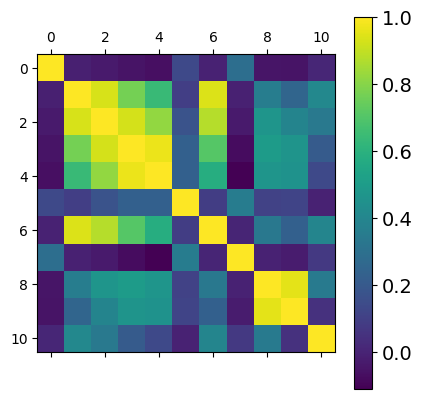

In [4235]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [4236]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

In [4237]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [4238]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([3396., 3396., 3396.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

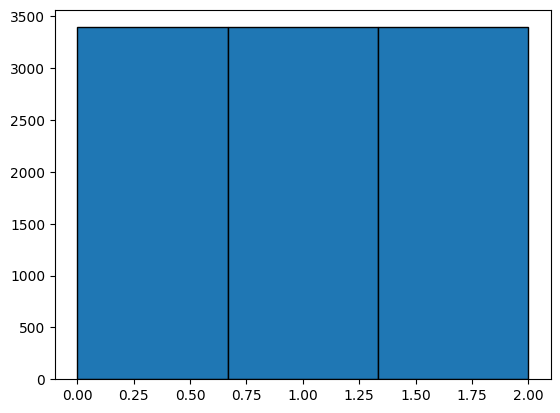

In [4239]:
plt.hist(y_train, bins=3, edgecolor='black')

(array([140., 140., 140.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

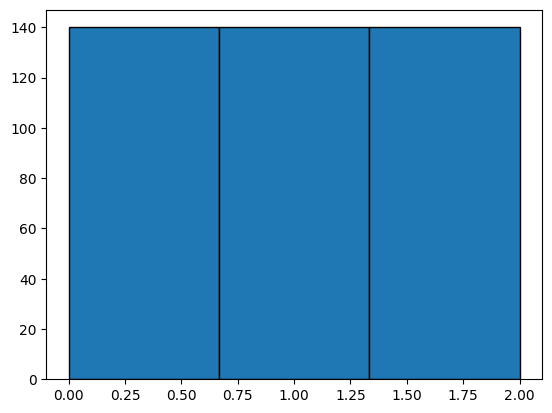

In [4247]:
plt.hist(y_test, bins=3, edgecolor='black')

In [4240]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [300, 350],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.6715744012563801
CPU times: total: 45.3 s
Wall time: 1min 17s


In [4241]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.3810

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.48      0.42       140
           1       0.45      0.07      0.12       140
           2       0.38      0.59      0.46       140

    accuracy                           0.38       420
   macro avg       0.40      0.38      0.34       420
weighted avg       0.40      0.38      0.34       420


Confusion Matrix:
[[67  6 67]
 [62 10 68]
 [51  6 83]]


In [4242]:
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

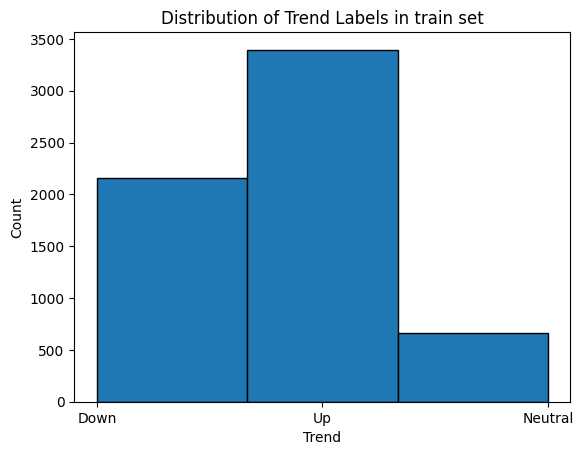

In [4248]:
plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

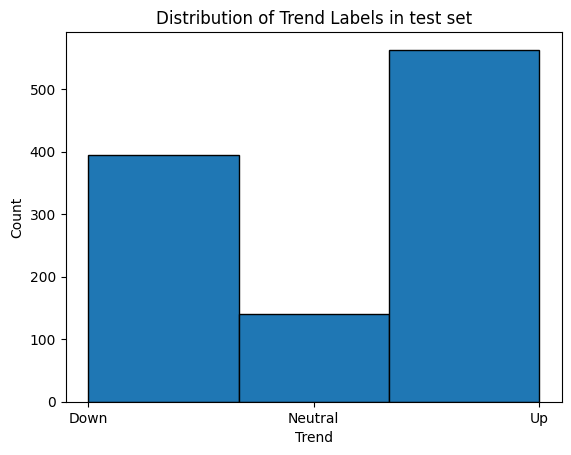

In [4244]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

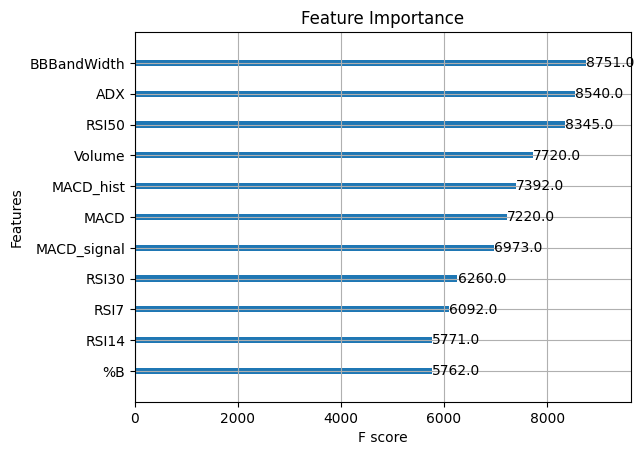

In [4245]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()